# Работа с базами данных

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Работа с базами данных"
* https://sqliteonline.com/
* https://docs.python.org/3/library/sqlite3.html
* https://www.sqlitetutorial.net/sqlite-create-table/
* https://docs.python.org/3/library/pickle.html
* https://www.geeksforgeeks.org/sql-join-set-1-inner-left-right-and-full-joins/
* https://www.datacamp.com/community/tutorials/group-by-having-clause-sql

## Задачи для совместного разбора

In [3]:
import pandas as pd
import sqlite3

In [36]:
students = pd.DataFrame(
    [
        ("Сотников Евгений Янович", 1),
        ("Степанова Виктория Константиновна", 1),
        ("Горелова Вероника Яновна", 2),
        ("Гришин Иван Романович", 3),
    ],
    columns=["name", "group_id"],
)


groups = list(zip([1, 2, 3], ["ПМ20-1", "ПМ20-2", "ПМ20-3"]))
groups

[(1, 'ПМ20-1'), (2, 'ПМ20-2'), (3, 'ПМ20-3')]

1. Создайте БД sqlite3 и таблицы Student и StudentGroup в ней.

In [2]:
con = sqlite3.connect("demo.db")

In [3]:
cur = con.cursor()

2. Заполните созданные таблицы данными

In [5]:
sql = """
CREATE TABLE StudentGroup(
    group_id INT PRIMARY KEY,
    group_name VARCHAR NOT NULL
);

CREATE TABLE Student(
    student_name VARCHAR PRIMARY KEY,
    group_id INT,
    FOREIGN KEY (group_id) REFERENCES StudentGroup(group_id)
)
"""
cur.executescript(sql)
con.commit() # транзакция 

In [6]:
#sql = """
#INSERT INTO StudentGroup(group_id, group_name)
#    VALUES (1, "ПМ20-1"), (2, "ПМ20-2")
#"""

sql = """
INSERT INTO StudentGroup(group_id, group_name)
    VALUES (?, ?)
"""

#cur.execute(sql, (1,"ПМ20-1"))

#for group in groups:
#    cur.execute(sql, group)

cur.executemany(sql, groups)
con.commit()

In [17]:
students.rename(columns={'name':'student_name'}).to_sql('Student', con, if_exists='replace', index=False)

4

In [19]:
pd.read_sql_query("SELECT * FROM Student", con)

,student_name,group_id
0,Сотников Евгений Янович,1
1,Степанова Виктория Константиновна,1
2,Горелова Вероника Яновна,2
3,Гришин Иван Романович,3


3. Выведите на экран фамилии студентов и номера их групп.

In [4]:
res = cur.execute("SELECT * FROM StudentGroup")
#res.fetchone()
#res.fetchmany(2)
res.fetchall()

[(1, 'ПМ20-1'), (2, 'ПМ20-2'), (3, 'ПМ20-3')]

In [5]:
cur.close()
con.close()

## Лабораторная работа 3

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

### Создание и заполнение базы данных

<p class="task" id="1"></p>

1\. Создайте файл БД sqlite3 согласно рисунку ниже, на котором определен набор таблиц и связей между ними. Обратите внимание, что поля, выделенные полужирным шрифтом, обозначают первичный ключ таблицы.

Для решения задания напишите скрипт на языке SQL и исполните его при помощи метода `executescript` объекта-курсора.

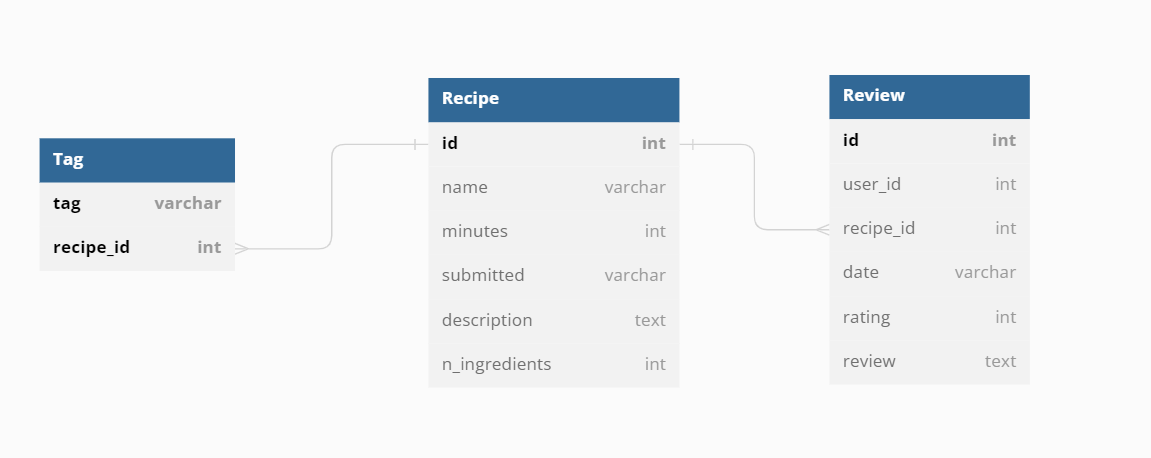

In [4]:
con = sqlite3.connect("first.db")

In [5]:
cur = con.cursor()

In [4]:
sql = """
CREATE TABLE Recipe(
    id int primary key,
    name varchar,
    minutes int,
    submitted varchar,
    description text,
    n_ingredients int
);
CREATE TABLE Tag(
    tag varchar,
    recipe_id int,
    PRIMARY KEY(tag, recipe_id),
    FOREIGN KEY (recipe_id) REFERENCES Recipe(id)
);

CREATE TABLE Review(
    id int primary key,
    user_id int,
    recipe_id int,
    date varchar,
    rating int,
    review text,
    FOREIGN KEY (recipe_id) REFERENCES Recipe(id)
)
"""
cur.executescript(sql)
con.commit()

In [84]:
cur.close()
con.close()

<p class="task" id="2"></p>

2\. Загрузите данные из файла `recipes_sample.csv` в таблицу `Recipe`. При выполнении задания воспользуйтесь методом `executemany` объекта-курсора.

In [6]:
recipes = pd.read_csv('recipes_sample.csv')
x = ['id', 'name', 'minutes', 'submitted', 'description', 'n_ingredients']

In [7]:
sql = """
INSERT INTO Recipe(id, name, minutes, submitted, description, n_ingredients)
    VALUES (?, ?, ?, ?, ?, ?)
"""
cur.executemany(sql, recipes[x].values.tolist())
con.commit()

IntegrityError: UNIQUE constraint failed: Recipe.id

In [36]:
# проверка
res = cur.execute("SELECT submitted, minutes FROM Recipe")
res.fetchmany(5)

[('2002-10-25', 90),
 ('2003-07-26', 10),
 ('2002-08-29', 30),
 ('2002-07-27', 45),
 ('2004-02-23', 25)]

<p class="task" id="3"></p>

3\. Загрузите данные из файла `reviews_sample.csv` в таблицу `Review`. При выполнении задания воспользуйтесь методом `pd.DataFrame.to_sql`.

In [53]:
reviews = pd.read_csv('reviews_sample.csv')
reviews.columns = ['id', 'user_id', 'recipe_id', 'date', 'rating', 'review']

In [28]:
reviews.to_sql('Review', con, if_exists='replace', index=False)

126696

In [29]:
# проверка
res = cur.execute("SELECT id, user_id FROM Review")
res.fetchmany()

[(370476, 21752)]

<p class="task" id="4"></p>

4\. Загрузите данные из файла `tags_sample.pickle` в таблицу `Tag`. При выполнении задания воспользуйтесь методом `executemany` объекта-курсора или методом `pd.DataFrame.to_sql`. 

Для считывания файла с данными воспользуйтесь пакетом `pickle`. Обратите внимание, что перед добавлением записей в базу данные нужно привести к соответствующему таблице в БД виду (в каждой строчке столбца tag должен находиться один тэг).

In [4]:
import pickle

In [61]:
with open('tags_sample.pickle', 'rb') as f:
    pk = pickle.load(f)

In [19]:
lst = []
for dic in pk:
    for tag in dic['tag']:
        lst.append((tag, dic['id']))

In [17]:
sql = """
INSERT INTO Tag(tag, recipe_id)
    VALUES (?, ?)
"""
cur.executemany(sql, lst)
con.commit()

In [18]:
# проверка
cur.execute("SELECT * FROM Tag").fetchone()

('pies', 48)

---
### Получение данных из базы

<p class="task" id="5"></p>

5\. Напишите и выполните запрос на языке SQL, который считает кол-во рецептов, опубликованных в 2010 году и имеющих длину не менее 15 минут. Для выполнения запроса используйте метод `execute` объекта-курсора. Выведите искомое количество на экран.

In [38]:
sql = """
SELECT count(id) FROM Recipe
WHERE strftime('%Y', submitted) = '2010' AND minutes >= 15
"""
cur.execute(sql).fetchmany(1)[0][0]

1319

<p class="task" id="6"></p>

6\. Напишите и выполните запрос на языке SQL, который возращает id рецептов, не имеющих ни одного отзыва отзывов с рейтингом, меньше 4. Для выполнения запроса используйте функцию `pd.read_sql_query`. Выведите полученный результат на экран.

In [4]:
sql = """SELECT DISTINCT Recipe.id 
FROM Recipe
JOIN Review
ON Recipe.id = Review.recipe_id
WHERE Recipe.id NOT IN (
SELECT Review.recipe_id FROM Review WHERE rating < 4
)
""" 
pd.read_sql_query(sql , con)

,id
0,252013
1,129396
2,31322
3,16067
4,33715
...,...
20461,422945
20462,94096
20463,154964
20464,187418


<p class="task" id="7"></p>

7\. Используя механизмы группировки и объединения, которые предоставляет SQL, выведите на экран названия и количество тегов 5 рецептов, которые имеют наибольшее количество тэгов. При выполнении задания воспользуйтесь методом `execute` объекта-курсора. Измерьте время выполнения работы вашего кода.

Вся необходимая логика (группировки, объединения, выбор топ-5 строк) должна быть реализована на SQL, а не в виде кода на Python.

In [72]:
sql = """
SELECT DISTINCT recipe_id 
FROM Tag 
GROUP BY (recipe_id)
ORDER BY (count(tag)) DESC
LIMIT 5
"""
cur.execute(sql).fetchmany(5)

[(66309,), (60942,), (72657,), (64386,), (35105,)]

<p class="task" id="8"></p>

8\. Запросите у пользователя id рецепта и верните информацию об этом рецепте. Если рецепт отсутствует, выведите соответствующее сообщение. Для подстановки значения id необходимо воспользоваться специальным синтаксисом, которые предоставляет `sqlite` для этих целей. Продемонстрируйте работоспособность вашего решения.

In [9]:
sql = """
SELECT * FROM Recipe
WHERE id = ?
"""

ID = [input()]

ans = cur.execute(sql, ID).fetchmany(1)

if ans:
    print(ans)
else:
    print('нет такого id!')

94096
[(94096, 'vegetable pasta pie', 105, '2004-06-23', "i've had this recipe for ages. i used to make it before i moved overseas. 2 things i always did differently was replace the ricotta with cottage cheese and i used a cast iron skillet as opposed to the springform pan. goes well with nice tossed salad. also try using wholemeal flour for pastry... i have done that and it made if very hearty and wholesome--especially if you use wholemeal pasta and stick with low fat cheeses.", 15)]
